In [2]:
from nltk.corpus import stopwords
from nltk import stem,pos_tag
import re
from collections import Counter
import numpy as np
from sklearn.cluster import KMeans
%pylab inline
from textblob import TextBlob
from sklearn.metrics import silhouette_score,confusion_matrix,accuracy_score,roc_curve
import pandas as pd
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize,Normalizer
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import ftfy
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.grid_search import GridSearchCV
import statsmodels.api as sm
from seaborn import lmplot
import os  # for os.path.basename
import matplotlib as mpl
from sklearn.manifold import MDS,TSNE
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD,PCA,NMF
from sklearn.pipeline import make_pipeline
from sklearn.decomposition.online_lda import LatentDirichletAllocation

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import dat

Populating the interactive namespace from numpy and matplotlib


## Function to get titles of talks

In [3]:
def get_titles_from_talks(talks):
    
    title = []
    # For all the talks in that category
    for talk in talks:
        # if the talk is not empty
        if talk != "":
            # split talk and the header
            h,s = talk.lower().split("\n\n")
            # Header contains the title and the number of views
            t,v = h.split("\n")
            # Get the titles
            title.append(t)
    return title

In [7]:
with open("entertainment.txt", 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks= list(set((talks)))
       
ent = get_titles_from_talks(talks)



with open("technology.txt", 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks = list(set((talks)))
       
tech = get_titles_from_talks(talks)




with open("science.txt", 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks = list(set((talks)))
       
science = get_titles_from_talks(talks)




with open("business.txt", 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks = list(set((talks)))
       
business = get_titles_from_talks(talks)




with open("global_issues.txt", 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks = list(set((talks)))
       
glob = get_titles_from_talks(talks)

## Getting the talks that occur only once over the whole corpus.

In [8]:
topic_c = Counter()
# loop over all the talk-titles in each of the category
for topic in [ent,tech,glob,business,science]:
    #increment the counter for that title if it occurs more than once
    topic_c += Counter(topic)
# unzip the counter object
topic,c = zip(*topic_c.items())
# select the talks that only occur once
titles = np.array(topic)[np.where(np.array(c)==1)]


### These single letter labels make it easy to unserstand the output in some places

s -> science --- 0

t -> Technology --- 1

b ->business --- 2

g ->global --- 3

e -> entertainment ---4

## Creating a dictionary of labels for all the talks

## These are the actual labels : I'm getting them beacuse I'm loading talks category wise.

In [9]:
d = {}

for title in titles:
    if title in tech:  # Talks in technology  have title "t"
        d[title]="t"
    if title in ent:# Talks in entertainment  have title "e"
        d[title]="e"
    if title in business: # Talks in business  have title "b"
        d[title]="b"
    if title in glob: # Talks in global issues  have title "g"
        d[title]="g"
    if title in science: # Talks in science  have title "s"
        d[title]="s"

## Category sizes/splits :

### business = 123

### entertainment = 152

### global issues = 245

### science = 209

### technology = 249

In [10]:
Counter(d.values())

D:\Anaconda3\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
D:\Anaconda3\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


Counter({'b': 123, 'e': 152, 'g': 245, 's': 209, 't': 249})

----

# we donot have much class imbalance. 

# Base line accuracy is 25-30%

-----

## Loading all the documents together, retaining all the punctuations to get a proper count of pauses and question marks for EDA

In [11]:
#Loading the file that contains all the talks. These belong to all the categories that we have
with open("all.txt", 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")

talks = list(set((talks)))
lemma = WordNetLemmatizer()
stop_w = stopwords.words("english")
views = []
speeches = []
title = []
labels = []
senti = []
talks.remove("")

# loop over talks
for talk in talks:
    

    # Split the header and the actual speech
    h,s = talk.lower().split("\n\n")
    #split the header , that contains title and the views
    t,v = h.split("\n")
    # If that title is predent in the talks that are unique , which we computed earlier
    if t in d:
        # some punctuation removal
        s = s.replace(". "," ").replace(", "," ").replace(","," ").replace("."," ").replace("  "," ").replace('"'," ")

        # removing stop words
        s = " ".join(i for i in s.split() if i not in stop_w)
        
        f = TextBlob(s)
        senti.append(f.polarity)
        
        speeches.append(s)
       
        labels.append(d[t])
        views.append(v)
        title.append(t)

## Creating labels in terms of numbers is useful, some functions need them .

In [12]:
# Creating a list of labels in terms on numbers

num_label = []
for i in labels:
    if i =="s":
        num_label.append(0)
    if i =="t":
        num_label.append(1)
    if i =="b":
        num_label.append(2)
    if i =="g":
        num_label.append(3)
    if i ==s:
        num_label.append(3)
    if i =="e":
        num_label.append(4)


## Counting functions for EDA

In [13]:
def count_pause(speeches):
    counts = []
    for s in speeches:
        counts.append(s.count("--")+s.count(" --")+s.count("-- "))
    return counts  
def count_questions(speeches):
    counts= []
    for s in speeches:
        counts.append(s.count("?")+s.count(" ?")+s.count("? "))
    return counts 
def count_laughters(speeches):
    counts= []
    for s in speeches:
        counts.append(s.count("(laughter)")+s.count("laughter"))
    return counts 
def count_applause(speeches):
    counts= []
    for s in speeches:
        counts.append(s.count("(applause)")+s.count("applause"))
    return counts 


In [14]:
views = np.array(views).astype(int)
d_ = {"views":views,"labels":labels,'sentiment':senti,'pause': count_pause(speeches), 'questions': count_questions(speeches),'laughter':count_laughters(speeches),"applause":count_applause(speeches)}
df_eda = pd.DataFrame(data=d_)

## EDA and summary stats:

In [15]:
df_ = df_eda.groupby("labels").sum()
df_

,applause,laughter,pause,questions,sentiment,views
labels,,,,,,
b,465,1094,2466,1859,15.456551,311733541
e,1033,2239,3620,2250,19.509218,299570723
g,1038,1130,5030,2689,23.226266,299169383
s,713,1747,3912,2272,24.151996,358767319
t,1200,1825,4437,2693,32.657017,383874921


Text(0.5,1,'sentiment')

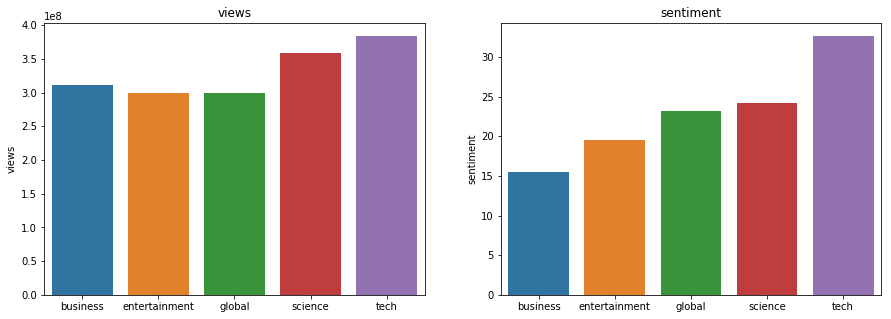

In [16]:
import seaborn as sns
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(["business","entertainment","global","science","tech"],df_.views)
plt.title("views")
plt.subplot(1,2,2)
sns.barplot(["business","entertainment","global","science","tech"],df_.sentiment)
plt.title("sentiment")

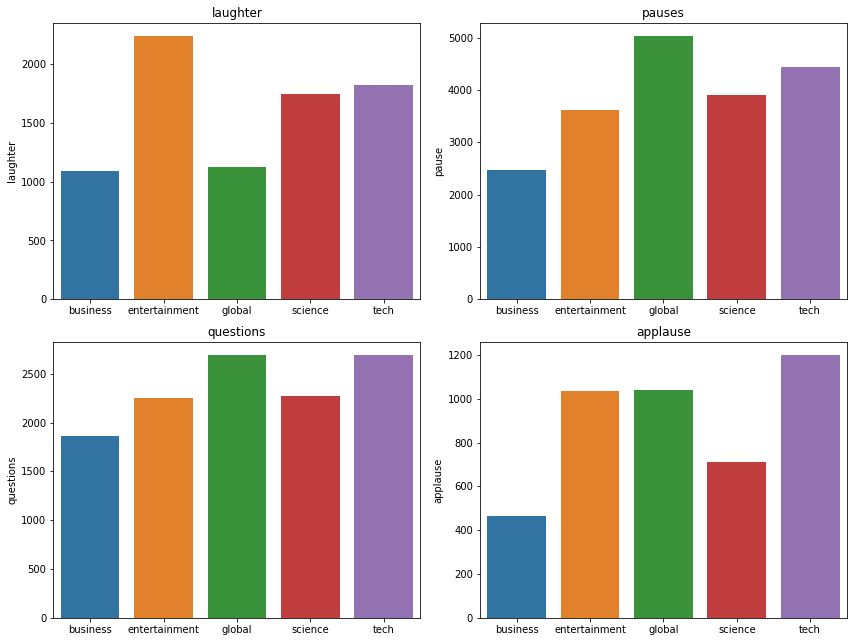

In [17]:
plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
sns.barplot(["business","entertainment","global","science","tech"],df_.laughter)
plt.title("laughter")
plt.subplot(2,2,2)
sns.barplot(["business","entertainment","global","science","tech"],df_.pause)
plt.title("pauses")
plt.subplot(2,2,3)
sns.barplot(["business","entertainment","global","science","tech"],df_.questions)
plt.title("questions")
plt.subplot(2,2,4)
sns.barplot(["business","entertainment","global","science","tech"],df_.applause)
plt.title("applause")
plt.tight_layout()

In [18]:
view = np.array(df_eda.views).astype(int)

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


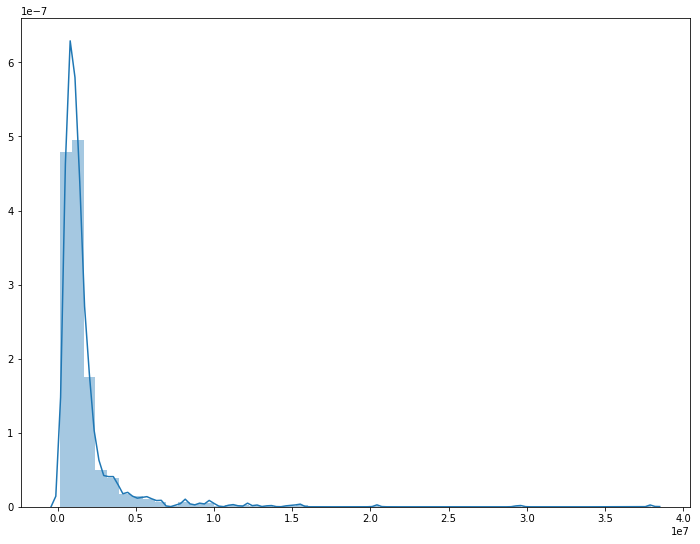

In [19]:
plt.figure(figsize=(12,9))
sns.distplot(view);

## Load all documents together, with all the preprocessing steps included

## Pre-processing:

1)  encoding

2) punctuation and symbols 

3)stop words removal

4) Lemmatization 

5)POS tagging  retaining NN and NNP


In [20]:
stop_w = stopwords.words("english")
stop_w.extend(["say","we're","said","things","becae","jt","it's",'one','like','people','going','know',"that's",'think','see','really',"get","would","i'm","don't","us","actually","may","always","found","fact","lost","you've","end"])
stop_w.extend(["sided","something","thing","got","also","we've","there's","time","well","way","want","could","first","two","new","they're","you're","take","back","need","many","kind","ever","four","five","used","maybe","start"])
stop_w.extend(["go","right","make","look","much","even","little","good","work","lot","put","use","three","come","around","different","another","i'll","ask","took","came","tell","great","find","i've","give","went","called","didn't","talk"])
stop_w.extend(["every","thank","day","big","can't","made","started","still","might","let's","idea","000","what's","years","year","able","start","example","question","show","problem","next","part","let","ago","doesn't","he's","here's","help"])
stop_w.extend(["almost","living","none","we'd","people's","using","says","okay","yet","10","second","i'd","goes","try","point","20","without","getting","happen","anything","else","wheather","true","ok","30","isn't","per","given","others","we'll","wouldn't","size","who's"])
stop_w.extend(["yeah","simple","laughing","laughter","(laughter)"])

In [22]:
with open("all.txt", 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")

talks = list(set((talks)))
lemma = WordNetLemmatizer()
views = []
speeches = []
title = []
labels = []
talks.remove("")

for talk in talks:
    


    h,s = talk.lower().split("\n\n")
    
    t,v = h.split("\n")
    
    if t in d:
        
        #BASIC PUNCTUATION REMOVAL
        
        s = s.replace(". "," ").replace(", "," ").replace(","," ").replace("."," ").replace("  "," ").replace('"'," ")
        s = s.replace("-- "," ").replace(" --"," ").replace("? "," ").replace("?"," ").replace("  "," ")
        s = re.sub(r"\((.\w+)\)","",s)
        
        #STOP WORDS removal and LEMMATIZING
        
        s = " ".join(lemma.lemmatize(i) for i in s.split() if i not in stop_w)
        
    
        words,tag = zip(*pos_tag(s.split()))
        # POS tagging 
        index = set(np.where(np.array(tag)=="NN")[0])
        np_index = set(np.where(np.array(tag)=="NNP")[0])
        index = list(index.union(np_index))
 
        words = np.array(words)[index]
        s = " ".join(i for i in words)
        speeches.append(s)
       
        labels.append(d[t])
        views.append(v)
        title.append(t)

## checking the word counts for better understanding

In [23]:
c = Counter()
#for each speech
for s in speeches:
    # counter for words
    c += Counter(s.split())
from operator import itemgetter
sorted_ = sorted(c.items(),key = itemgetter(1),reverse=True)[:10]
w,c = zip(*sorted_)

## Plotting the word counts 

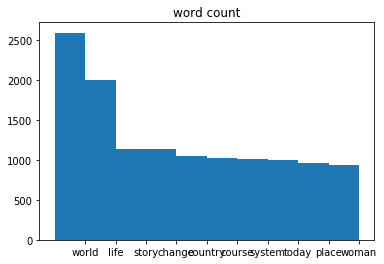

In [24]:
indexes = np.arange(len(w))
width = 1

plt.bar(indexes, c, width)
plt.xticks(indexes + width * 0.5, w)
plt.title("word count")
plt.show()

## Count Vectorizer, Tfidf vectorizer

In [25]:
df = pd.DataFrame(speeches)
df.columns=["speeches"]
df["labels"]=labels
# TFIDF VECTORIZER

tfidf_model =TfidfVectorizer(max_df=0.95 , min_df=2  , stop_words=stop_w)

vectorized_tfidf = tfidf_model.fit_transform(df.speeches)

#COUNT VECTORIZER

tf_model =CountVectorizer(max_df=0.95 , min_df=2  , stop_words=stop_w)

vectorized_tf = tf_model.fit_transform(df.speeches)


## Visualizing the TFIDF vectors using a manifold similarity between document vectors:

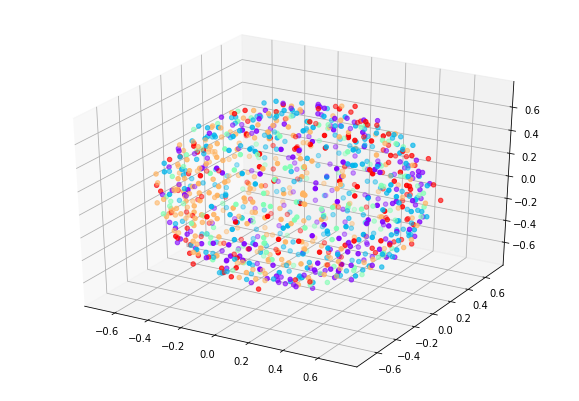

In [26]:
dist = 1 - cosine_similarity(vectorized_tfidf)
MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys, zs = pos[:, 0], pos[:, 1],pos[:,2]

fig = pylab.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection ="3d")
sc = ax.scatter(xs,ys,zs,c=num_label,cmap=plt.cm.rainbow)


> Visualizing the similarities among the document vectors. There is no clear pattern , but we will see by the end of the project that the doc2vec document vectors will make more sense. 

## Running LDA  on count vectorized documents. LDA on count vectorized vectors gave better results as compared to LDA on TFIDF.

In [27]:
# build LDA model

lda = LatentDirichletAllocation(n_topics=5,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)

lda.fit(vectorized_tf)
topics_words = lda.components_
words = tf_model.get_feature_names()

# Print the words that represent the topics

def print_top_words(model,words,n_top_words=20):
    for index,topic in enumerate(model.components_):
        print("Topic #%d:" % index)
        print("|".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
print("Topics in LDA model:")
tf_feature_names = tf_model.get_feature_names()
print_top_words(lda, tf_feature_names)

D:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topics in LDA model:
Topic #0:
sw|fraud|reputation|loan|world|ooh|liar|airbnb|power|einstein|change|crisis|country|recipe|birthday|orange|aah|mortgage|fiery|kiss
Topic #1:
dh|autism|heh|slime|summit|vulture|mountain|dog|climber|mold|rw|please|sobule|mogadishu|life|wolf|jill|barry|howard|together
Topic #2:
crow|bj|cousin|joey|cane|ak|peanut|sylvia|puppet|family|hyena|coin|plywood|horse|music|propeller|world|slot|life|woman
Topic #3:
world|life|story|change|country|today|course|system|place|woman|percent|number|technology|sort|school|child|brain|state|bit|word
Topic #4:
world|yemeni|oxytocin|life|system|toast|country|maestro|woman|percent|dudamel|story|course|today|gustavo|family|change|inspection|hi|sea


a,b=zip(*nltk.pos_tag(speeches[2].split()))
index = np.where(np.array(b)=="NN")
list(index).extend(np.where(np.array(b)=="NNP"))
np.array(a)[index]

## How LDA performs compares to the actual labels that we have :

In [28]:
v = lda.transform(vectorized_tf)
Counter([np.argmax(i) for i in v])

Counter({0: 3, 1: 6, 3: 969})

> It doesnt perform that well, we can see that the documents are unevenly distributed among the clusters. But we donot have any class imbalance in our data.

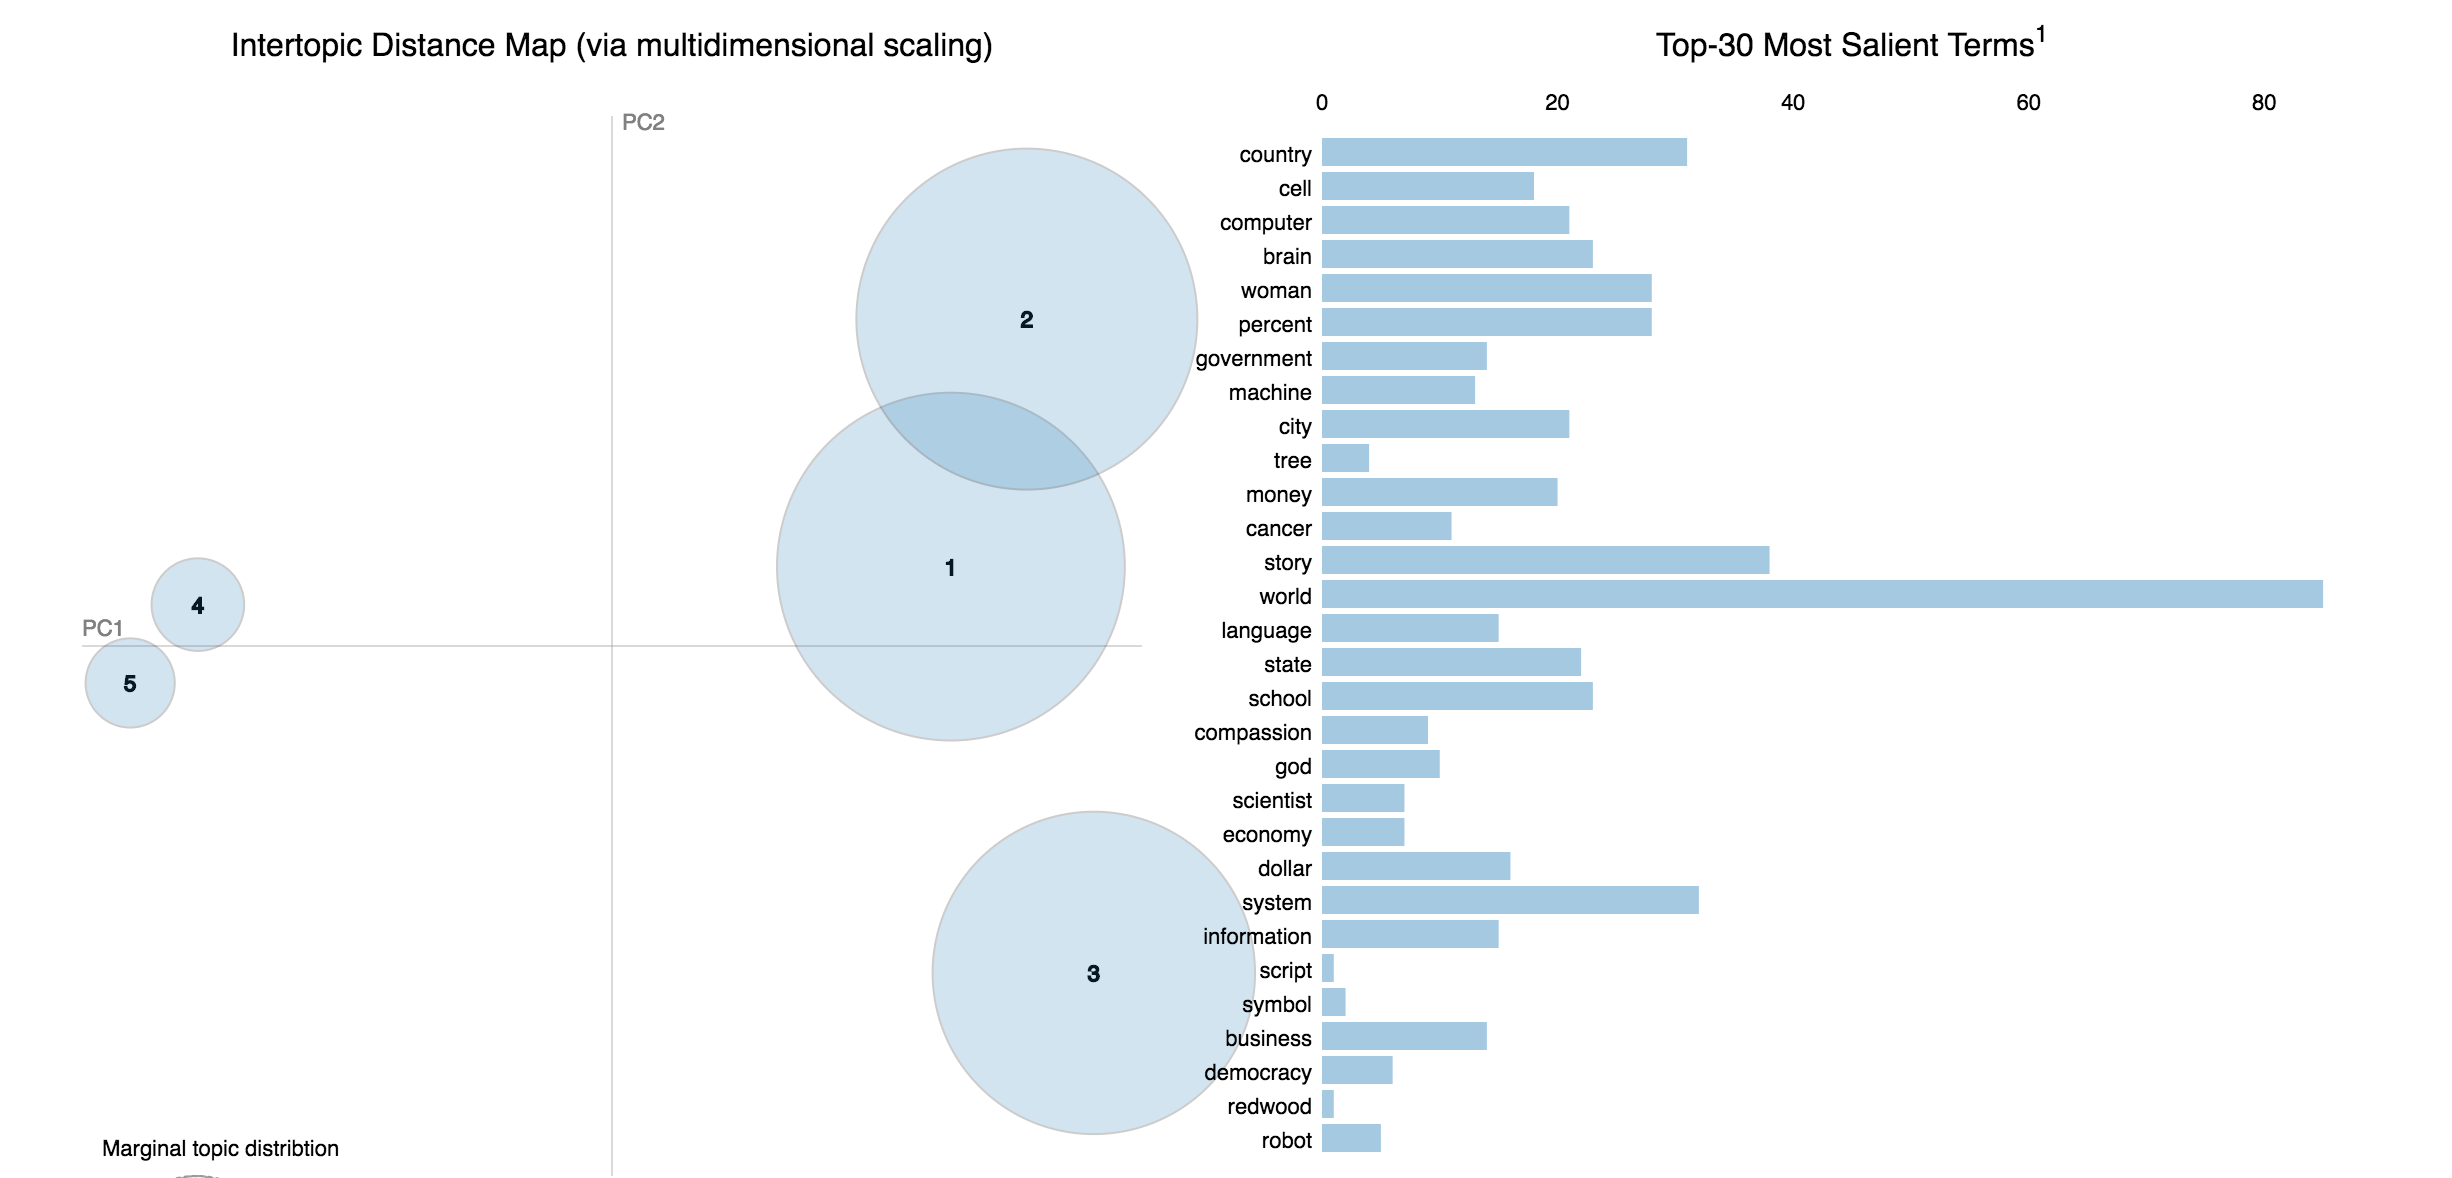

In [30]:
from IPython.display import Image
Image(filename='images/LDA_clusters.png', width=1000)

In [31]:
pyLDAvis.sklearn.prepare(lda,vectorized_tfidf,tfidf_model)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      90.541203        1       1  0.174502  0.000629
1       2.635601        1       2 -0.044161  0.032955
0       2.419269        1       3 -0.029859 -0.018221
2       2.249728        1       4 -0.055257 -0.010635
4       2.154199        1       5 -0.045225 -0.004728, topic_info=      Category       Freq        Term      Total  loglift  logprob
term                                                              
11440  Default  86.000000       world  86.000000  30.0000  30.0000
5992   Default  64.000000        life  64.000000  29.0000  29.0000
6814   Default   5.000000    mountain   5.000000  28.0000  28.0000
7934   Default  18.000000       power  18.000000  27.0000  27.0000
7784   Default   5.000000      please   5.000000  26.0000  26.0000
3136   Default   4.000000         dog   4.000000  25.0000  25.0000
2410   Default  33.000000     country  33.000000  24.0000  24.0000
3806   Default  18.000000      family  18.000000  23.0000  23.0000
4045   Default   7.000000        foot   7.000000  22.0000  22.0000
614    Default   2.000000      autism   2.000000  21.0000  21.0000
1645   Default  36.000000      change  36.000000  20.0000  20.0000
2915   Default   2.000000          dh   2.000000  19.0000  19.0000
10147  Default  32.000000      system  32.000000  18.0000  18.0000
2498   Default   4.000000      crisis   4.000000  17.0000  17.0000
11381  Default  29.000000       woman  29.000000  16.0000  16.0000
7047   Default  25.000000      number  25.000000  15.0000  15.0000
6180   Default  12.000000     machine  12.000000  14.0000  14.0000
6095   Default   2.000000        loan   2.000000  13.0000  13.0000
2610   Default   4.000000       dance   4.000000  12.0000  12.0000
9617   Default   6.000000        song   6.000000  11.0000  11.0000
1560   Default   6.000000       cause   6.000000  10.0000  10.0000
7668   Default  17.000000     picture  17.000000   9.0000   9.0000
7367   Default   3.000000        park   3.000000   8.0000   8.0000
656    Default   6.000000        baby   6.000000   7.0000   7.0000
4609   Default  20.000000        hand  20.000000   6.0000   6.0000
3626   Default  13.000000   everybody  13.000000   5.0000   5.0000
3750   Default  14.000000         eye  14.000000   4.0000   4.0000
2429   Default  33.000000      course  33.000000   3.0000   3.0000
4560   Default  19.000000         guy  19.000000   2.0000   2.0000
7580   Default  21.000000      person  21.000000   1.0000   1.0000
...        ...        ...         ...        ...      ...      ...
1501    Topic5   0.026233       caror   0.125126   2.2754  -8.8398
7573    Topic5   0.024877  perpetuate   0.124224   2.2296  -8.8929
10626   Topic5   0.024390  toleration   0.123415   2.2164  -8.9126
5800    Topic5   0.025504       labis   0.129640   2.2118  -8.8680
8506    Topic5   0.034287      refine   0.185359   2.1502  -8.5721
11563   Topic5   0.042608       youin   0.334010   1.7786  -8.3548
4816    Topic5   0.068300          hi   1.689404   0.6295  -7.8829
11440   Topic5   0.265720       world  86.544889  -1.9482  -6.5244
10147   Topic5   0.140611      system  32.404229  -1.6023  -7.1608
5992    Topic5   0.165335        life  64.872057  -2.1344  -6.9988
2410    Topic5   0.128670     country  33.681422  -1.7297  -7.2496
8646    Topic5   0.053306  reputation   1.422354   0.5537  -8.1308
11381   Topic5   0.103500       woman  29.355109  -1.8099  -7.4672
9129    Topic5   0.067244         sea   6.348462  -0.7099  -7.8985
7541    Topic5   0.086517     percent  28.788344  -1.9696  -7.6465
614     Topic5   0.054784      autism   2.507984   0.0139  -8.1034
3806    Topic5   0.075352      family  18.395962  -1.6600  -7.7846
2429    Topic5   0.081625      course  33.207613  -2.1706  -7.7047
10595   Topic5   0.081188       today  33.234426  -2.1768  -7.7101
9869    Topic5   0.081760       story  36.894400  -2.2743  -7.7030
5831    Topic5   0.066523   

## NMF - Topic Modeling using TFIDF 

In [32]:
#Build te NMF Model

nmf = NMF(init="nndsvd",
            n_components=5,
            max_iter=200)
nmf.fit(vectorized_tfidf)
topics_words = nmf.components_
words = tfidf_model.get_feature_names()

print("Topics in NMF model:")
tf_feature_names = tfidf_model.get_feature_names()
print_top_words(nmf, tf_feature_names)

Topics in NMF model:
Topic #0:
country|government|world|money|percent|state|dollar|business|school|democracy|health|economy|company|change|today|society|power|market|education|aid
Topic #1:
computer|music|machine|sort|technology|video|robot|design|project|information|car|phone|play|guy|language|image|world|space|person|sound
Topic #2:
woman|story|life|compassion|man|family|girl|child|mother|war|god|world|school|son|love|job|death|face|daughter|violence
Topic #3:
brain|cell|cancer|drug|disease|body|patient|trial|health|blood|tumor|gene|neuron|heart|treatment|stem|study|dna|doctor|culture
Topic #4:
water|city|planet|earth|energy|life|space|food|sea|plant|world|climate|place|system|change|ice|river|air|percent|surface


## Manual labelling of the topics

0 -->  global

1 -->  technology

2 -->  science

3 --> entertainment

4 ---> business


## Checking performance of Topic Modeling

In [33]:
v = nmf.transform(vectorized_tfidf)

Counter([np.argmax(i) for i in v])

Counter({0: 151, 1: 323, 2: 198, 3: 118, 4: 188})

In [34]:
highest_weighted_topics = [np.argmax(i) for i in v]

> We can see that the documents are almost equally distributed over all the categories, which is how our initial data was divided into categories

### Manually labelling the topics 

In [35]:
p = []
for i in highest_weighted_topics:
    if i == 0:
        p.append("t") # global issues
    if i ==1:
        p.append("b") # tech
    if i ==2:
        p.append("s") # business
    if i ==3:
        p.append("g") # science
    if i ==4:
        p.append("e") # entertainment


# Very important ***  

# Make sure you label the topics manually every time you re-run NMF.  

# NMF assigns random numbers to the topics that it prints. So read the words , label the topics using the previous cell. That is ->   p....    and then check for accuracy

## I'm checking  for accuracy after doing the labeling 

In [36]:
print("accuracy of my topic modeling : ",np.round(accuracy_score(labels,p)*100),"%")

accuracy of my topic modeling :  9.0 %


## I'm getting an accuracy of 44% which is better than most of the classifiers that I tried on the tfidf matrix.


## Visualizing the NMF model: There is a clear seperation between the topics, and they all make perfect sense when we examine the words in each topic.

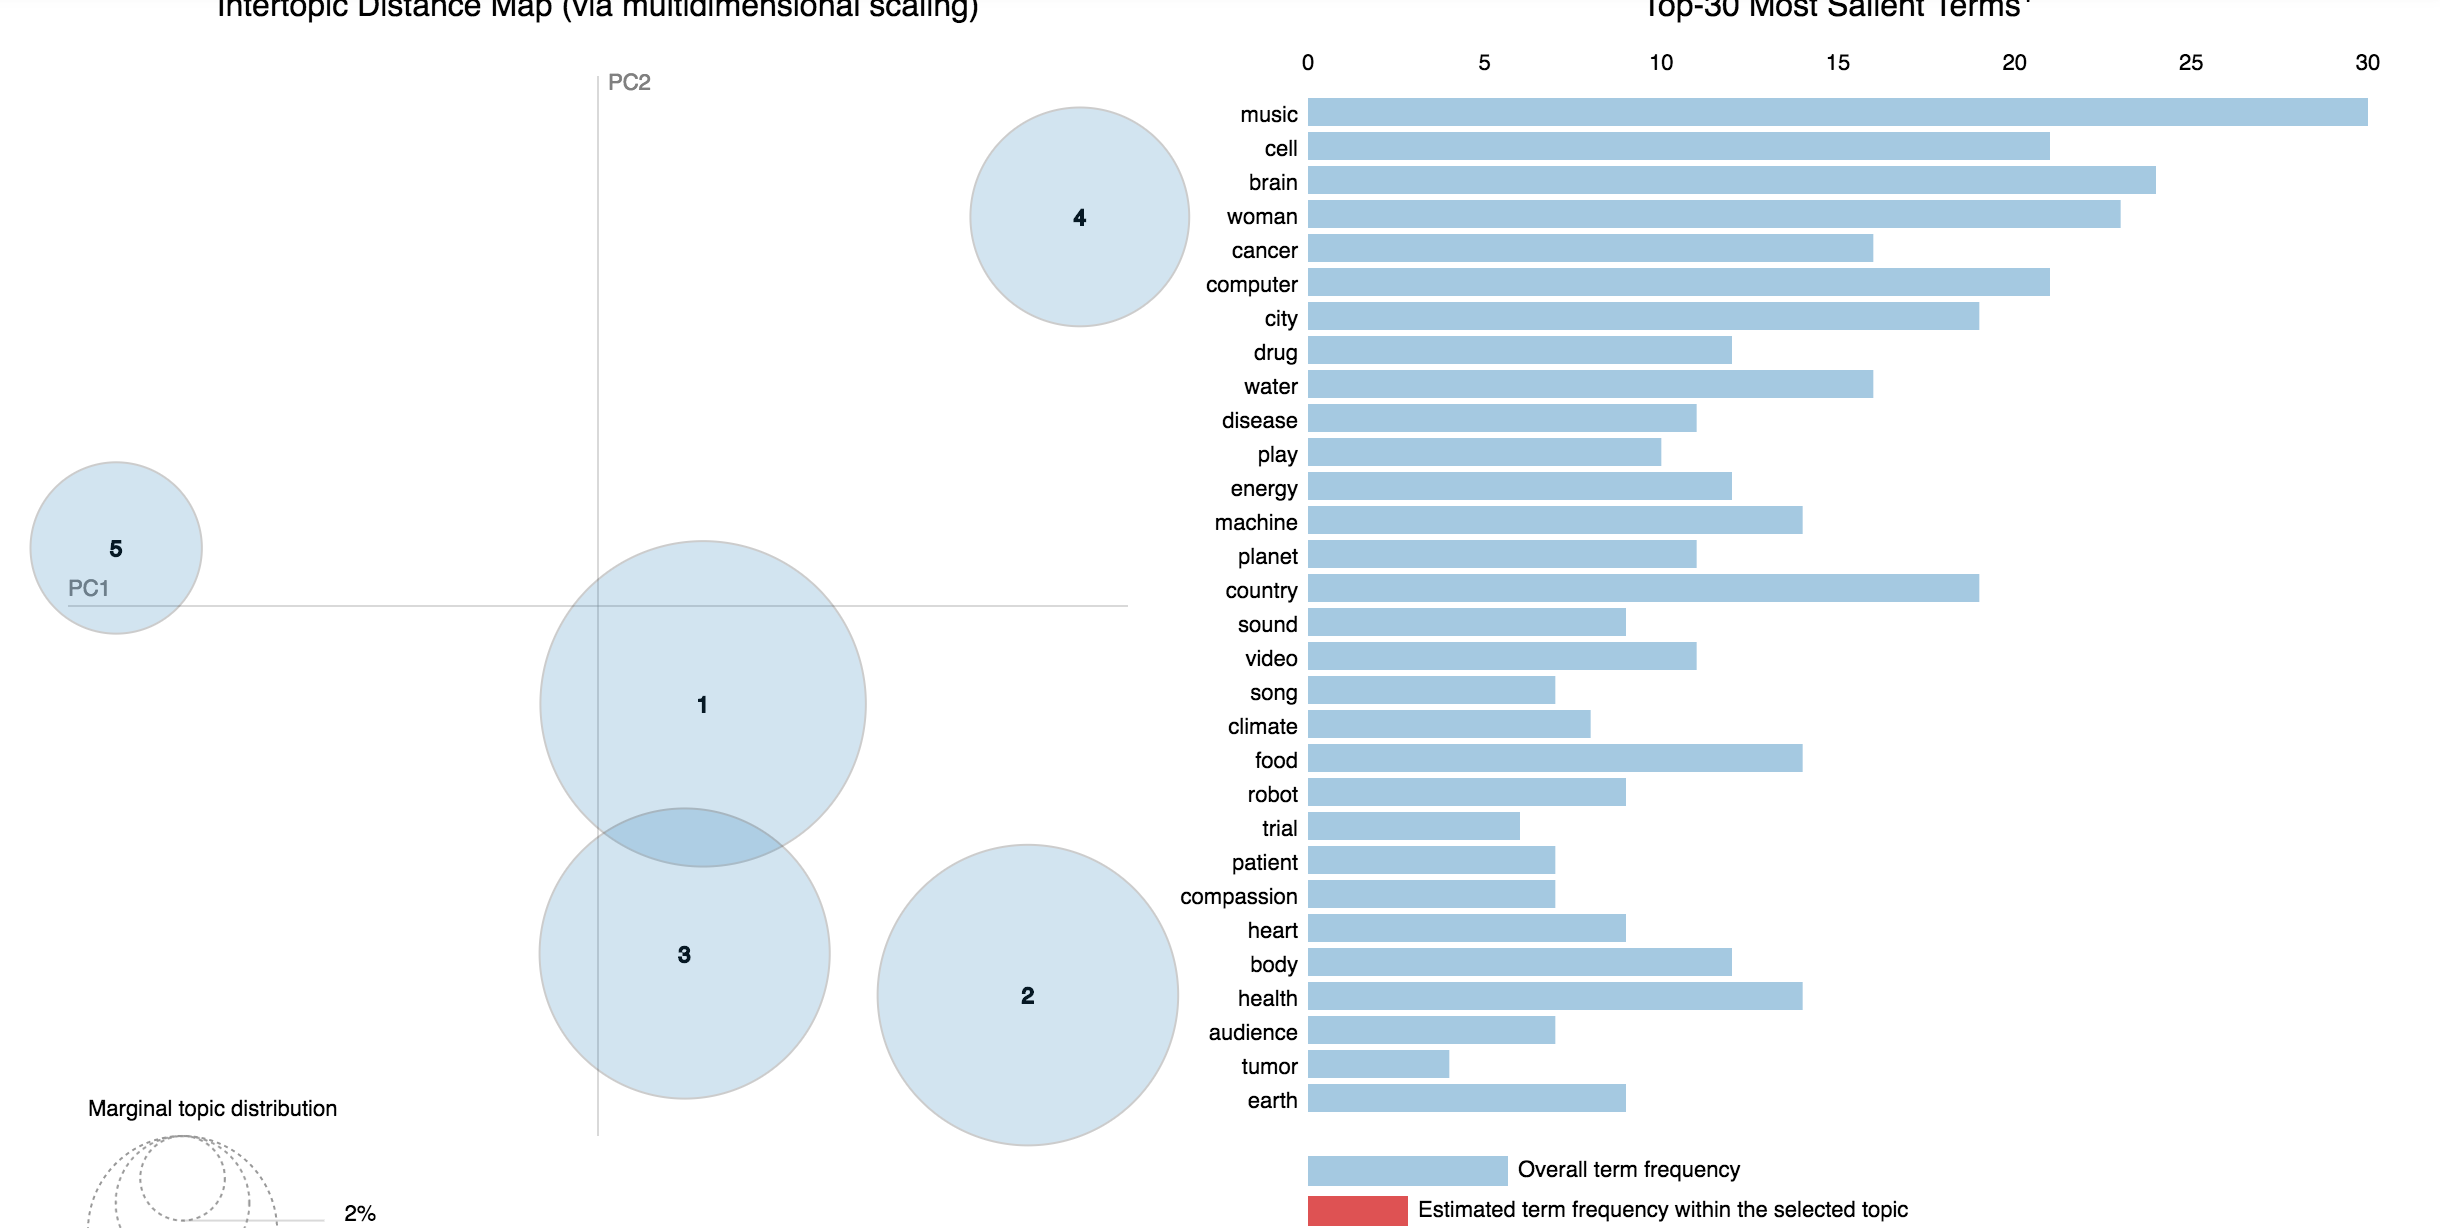

In [37]:
from IPython.display import Image
Image(filename='images/NMF_clusters.png', width=1000)

In [38]:
pyLDAvis.sklearn.prepare(nmf,vectorized_tfidf,tfidf_model)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      28.103017        1       1  0.011299 -0.008854
2      20.858048        1       2  0.163802  0.068055
0      19.603964        1       3  0.129527 -0.014030
4      19.602716        1       4 -0.106566 -0.198666
3      11.832256        1       5 -0.198062  0.153494, topic_info=      Category       Freq        Term      Total  loglift  logprob
term                                                              
11381  Default  30.000000       woman  30.000000  30.0000  30.0000
1167   Default  23.000000       brain  23.000000  29.0000  29.0000
1581   Default  19.000000        cell  19.000000  28.0000  28.0000
1424   Default  15.000000      cancer  15.000000  27.0000  27.0000
11207  Default  17.000000       water  17.000000  26.0000  26.0000
2121   Default  20.000000    computer  20.000000  25.0000  25.0000
2410   Default  19.000000     country  19.000000  24.0000  24.0000
7735   Default  12.000000      planet  12.000000  23.0000  23.0000
3274   Default  12.000000        drug  12.000000  22.0000  22.0000
4432   Default  12.000000  government  12.000000  21.0000  21.0000
1832   Default  17.000000        city  17.000000  20.0000  20.0000
2075   Default  11.000000  compassion  11.000000  19.0000  19.0000
3037   Default  11.000000     disease  11.000000  18.0000  18.0000
6871   Default  13.000000       music  13.000000  17.0000  17.0000
6180   Default  13.000000     machine  13.000000  16.0000  16.0000
3322   Default  10.000000       earth  10.000000  15.0000  15.0000
3488   Default  12.000000      energy  12.000000  14.0000  14.0000
6735   Default  11.000000       money  11.000000  13.0000  13.0000
4335   Default   9.000000        girl   9.000000  12.0000  12.0000
9869   Default  20.000000       story  20.000000  11.0000  11.0000
9129   Default   7.000000         sea   7.000000  10.0000  10.0000
4735   Default  13.000000      health  13.000000   9.0000   9.0000
11050  Default   9.000000       video   9.000000   8.0000   8.0000
8837   Default   9.000000       robot   9.000000   7.0000   7.0000
2789   Default   6.000000   democracy   6.000000   6.0000   6.0000
9649   Default  14.000000       space  14.000000   5.0000   5.0000
7431   Default   7.000000     patient   7.000000   4.0000   4.0000
10785  Default   6.000000       trial   6.000000   3.0000   3.0000
6798   Default   9.000000      mother   9.000000   2.0000   2.0000
7748   Default   7.000000       plant   7.000000   1.0000   1.0000
...        ...        ...         ...        ...      ...      ...
10785   Topic5   5.047909       trial   6.191953   1.9301  -5.2835
10583   Topic5   2.173508      tissue   2.483433   2.0010  -6.1261
3274    Topic5   9.530097        drug  12.544825   1.8595  -4.6480
1043    Topic5   4.820854       blood   6.018986   1.9124  -5.3295
2366    Topic5   1.903757      cortex   2.219953   1.9807  -6.2586
6168    Topic5   1.917753        lung   2.239169   1.9794  -6.2513
10420   Topic5   1.871549     therapy   2.181829   1.9809  -6.2757
4270    Topic5   4.392966        gene   5.894832   1.8403  -5.4225
7431    Topic5   5.413816     patient   7.583452   1.7973  -5.2135
10767   Topic5   4.010842   treatment   5.530294   1.8131  -5.5135
2560    Topic5   2.074287        cure   2.698607   1.8712  -6.1729
1199    Topic5   2.553302      breast   3.596551   1.7918  -5.9651
6429    Topic5   2.262251    medicine   3.122385   1.8121  -6.0861
3111    Topic5   3.718980         dna   5.967541   1.6615  -5.5890
8196    Topic5   2.282594     protein   3.214517   1.7920  -6.0772
11031   Topic5   1.426854      vessel   1.771835   1.9178  -6.5470
10061   Topic5   2.365128     surgery   3.535377   1.7324  -6.0416
1074    Topic5   5.456766        body  11.785163   1.3644  -5.2056
4746    Topic5   4.190967       heart   8.845374   1.3874  -5.4695
6716    Topic5   2.679788    molecule   4.543283   1.6064  -5.9167
4735    Topic5   5.004382   

## Kmeans on the reduced dimensions (W matrix of NMF,  NMF->  A= W*H)  of these document vectors

Text(0,0.5,'Silhouette score')

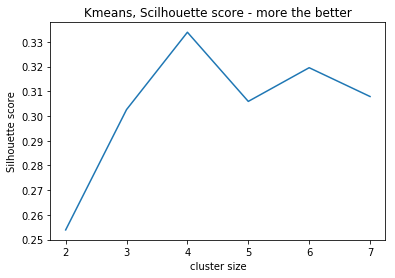

In [39]:
s=[]
for i in range(2,8):
    km = KMeans(n_clusters=i)
    km.fit(v)
    p=km.predict(v)
    s.append(silhouette_score(v,p))
    
plt.plot(range(2,8),s)
plt.title("Kmeans, Scilhouette score - more the better")
plt.xlabel("cluster size")
plt.ylabel("Silhouette score")

> Perfect !!  Silhouette score tells us that the best cluster size is 5. Which is what we expected.

## Tuning Parameters for SVM classifier

In [40]:
X_train,X_test, y_train,y_test = train_test_split(vectorized_tfidf,labels,random_state=42)

#### Default SVM parameters: 

In [41]:
svc = SVC()
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
accuracy_score(y_test,y_pred)

0.24081632653061225

### Grid search

In [42]:
svc_grid_var = {'C':[1,10,100,500],
              'gamma':[1,10,100],
              "kernel":["rbf","poly","sigmoid","linear"]}

svc_gridsearch = GridSearchCV(SVC(),svc_grid_var,verbose=True,scoring="accuracy")

best_model_svc = svc_gridsearch.fit(vectorized_tfidf,labels)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.6min finished


### Fitting best svm model

In [43]:
best_model_svc.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [44]:
best_model_svc.best_estimator_.fit(X_train,y_train)
y_pred = best_model_svc.predict(X_test)

In [45]:
accuracy_score(y_test,y_pred)

0.7142857142857143

In [46]:
print("SVM accuracy :",accuracy_score(y_test,y_pred)*100,"%")

SVM accuracy : 71.4285714286 %


## Confusion Matrix SVM 

In [47]:
conf = pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=y_pred))
conf.columns = ["business","entertain","global","science","tech"]
conf.index = ["business","entertain","global","science","tech"]
conf.columns.name = "True\Predicted"
conf

True\Predicted,business,entertain,global,science,tech
business,15,3,9,3,11
entertain,0,29,5,2,2
global,1,0,47,3,5
science,0,2,4,42,3
tech,1,2,4,10,42


## ROC -- SVM

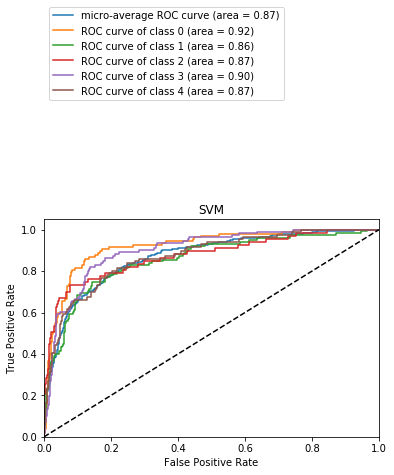

In [48]:
# sklearn code

y = label_binarize(num_label, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(df.speeches, y, test_size=.5,random_state=0)
cv = TfidfVectorizer(max_df=0.95 , min_df=2  , stop_words=stop_w)
cv.fit(X_train)
X_train,X_test = cv.transform(X_train),cv.transform(X_test)
classifier = OneVsRestClassifier(best_model_svc.estimator)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
#y_score[:,0]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:,i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("SVM")
plt.legend(bbox_to_anchor=(0, 2), loc='upper left', ncol=1)
plt.show()

## Random forest 

##  Choosing the default random forest parameters. I changed only number of trees.

In [49]:
RF = RandomForestClassifier(n_estimators=2000)
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)


In [50]:
print("Random Forest Accuracy :",accuracy_score(y_test,y_pred))

Random Forest Accuracy : 0.132924335378


## Grid search on Random forest

In [51]:

X_train,X_test,y_train,y_test = train_test_split(vectorized_tfidf,num_label,random_state=52)

In [52]:

rf_grid_var = {'n_estimators':[2000],
              "max_depth":[3,4,5]}

rf_gridsearch = GridSearchCV(RandomForestClassifier(),rf_grid_var,verbose=True,scoring="mean_squared_error")

best_model = rf_gridsearch.fit(vectorized_tfidf,num_label)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


D:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
D:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
D:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
D:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
D:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning

In [53]:
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
accuracy_score(y_test,y_pred)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


D:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
D:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
D:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
D:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
D:\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning

0.49795918367346936

### Confusion Matrix

In [54]:
conf = pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=y_pred))
conf.columns = ["business","entertain","global","science","tech"]
conf.index = ["business","entertain","global","science","tech"]
conf.columns.name = "True\Predicted"
conf

True\Predicted,business,entertain,global,science,tech
business,21,22,0,8,0
entertain,3,47,0,8,0
global,0,16,0,13,0
science,0,13,0,54,0
tech,1,34,0,5,0


## Plotting the ROC curve


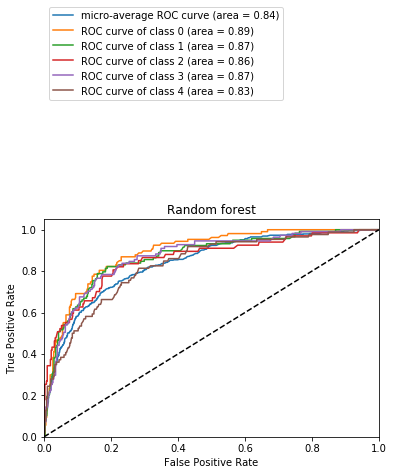

In [55]:

def plot_roc(clf,name):
    y = label_binarize(num_label, classes=[0, 1, 2, 3, 4])
    n_classes = y.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(df.speeches, y, test_size=.5,random_state=0)
    cv = TfidfVectorizer(max_df=0.95 , min_df=2  , stop_words=stop_w)
    cv.fit(X_train)
    X_train,X_test = cv.transform(X_train),cv.transform(X_test)
    classifier = OneVsRestClassifier(clf)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    #y_score[:,0]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:,i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(bbox_to_anchor=(0, 2), loc='upper left', ncol=1)
    plt.show()
plot_roc(RandomForestClassifier(n_estimators=2000),"Random forest")

## KNN

### Parameter tuning for knn

In [56]:
X_train,X_test,y_train,y_test = train_test_split(vectorized_tfidf,labels,random_state=52)
score_test =[]
score_train = []
for n in range(1,30):
    KNN = KNeighborsClassifier(n_neighbors=n)
    KNN.fit(X_train,y_train)
    p_train = KNN.predict(X_train)
    p_test = KNN.predict(X_test)
    score_train.append(accuracy_score(y_train,p_train))
    score_test.append(accuracy_score(y_test,p_test))

### Finding best K

best k size : 8


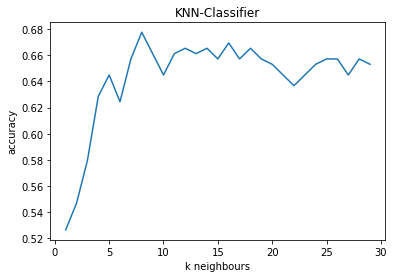

In [57]:
plt.plot(range(1,30),score_test,label = "Test")
plt.xlabel("k neighbours")
plt.ylabel("accuracy")
plt.title("KNN-Classifier")
print("best k size :",range(1,30)[np.argmax(score_test)])
best_k = range(1,30)[np.argmax(score_test)];

## Train and Test vs Model complexity : 

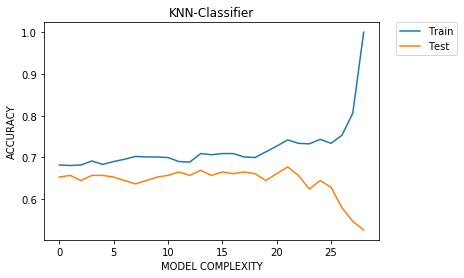

In [58]:
plt.plot(score_train[::-1],label = "Train")
plt.plot(score_test[::-1],label = "Test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("MODEL COMPLEXITY")
plt.ylabel("ACCURACY")
plt.title("KNN-Classifier");

### Running the best model

In [59]:
KNN = KNeighborsClassifier(n_neighbors=best_k)
KNN.fit(X_train,y_train)
y_pred = KNN.predict(X_test)
print("Accuracy KNN: ",accuracy_score(y_test,y_pred)*100)

Accuracy KNN:  67.7551020408


In [60]:
conf = pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=y_pred))
conf.columns = ["business","entertain","global","science","tech"]
conf.index = ["business","entertain","global","science","tech"]
conf.columns.name = "True\Predicted"
conf

True\Predicted,business,entertain,global,science,tech
business,13,2,10,1,3
entertain,1,21,9,5,4
global,4,1,59,2,1
science,0,2,13,31,5
tech,2,4,5,5,42


## ROC KNN : 

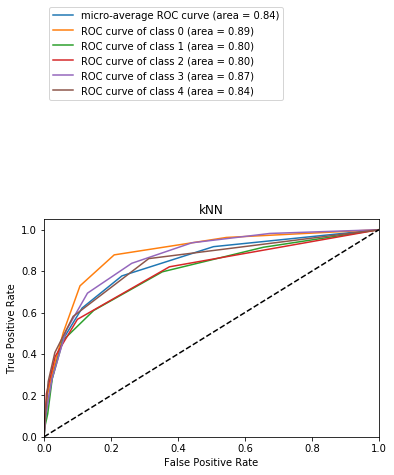

In [61]:
plot_roc(KNeighborsClassifier(n_neighbors=7),"kNN")

## Gradient Boosting

In [62]:
GB = GradientBoostingClassifier(n_estimators=300)
GB.fit(X_train,y_train)
p = GB.predict(X_test.toarray())
accuracy_score(y_test,p)

0.60816326530612241

## Confusion Matrix :

In [63]:
conf = pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=y_pred))
conf.columns = ["business","entertain","global","science","tech"]
conf.index = ["business","entertain","global","science","tech"]
conf.columns.name = "True\Predicted"
conf

True\Predicted,business,entertain,global,science,tech
business,13,2,10,1,3
entertain,1,21,9,5,4
global,4,1,59,2,1
science,0,2,13,31,5
tech,2,4,5,5,42


## LDA does not perform well :

In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train, X_test, y_train, y_test = train_test_split(vectorized_tfidf, labels, test_size=.5,random_state=0)
s = []
for n in range(2,10):
    linear_da = LinearDiscriminantAnalysis(n_components=n)
    linear_da.fit(X_train.toarray(),y_train)
    p = linear_da.predict(X_test)
    s.append(accuracy_score(y_test,p))

D:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [65]:
max(s)

0.46421267893660534

## Default LDA

In [66]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train, X_test, y_train, y_test = train_test_split(vectorized_tfidf, labels, test_size=.5,random_state=0)
lda_ =  LinearDiscriminantAnalysis()
lda_.fit(X_train.toarray(),y_train)
y_pred = lda_.predict(X_test)
accuracy_score(y_test,y_pred)


D:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.46421267893660534

In [67]:
conf = pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=y_pred))
conf.columns = ["business","entertain","global","science","tech"]
conf.index = ["business","entertain","global","science","tech"]
conf.columns.name = "True\Predicted"
conf

True\Predicted,business,entertain,global,science,tech
business,2,2,40,2,21
entertain,2,13,31,8,32
global,1,2,91,2,15
science,0,1,21,49,36
tech,0,1,27,18,72


## ROC :

D:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


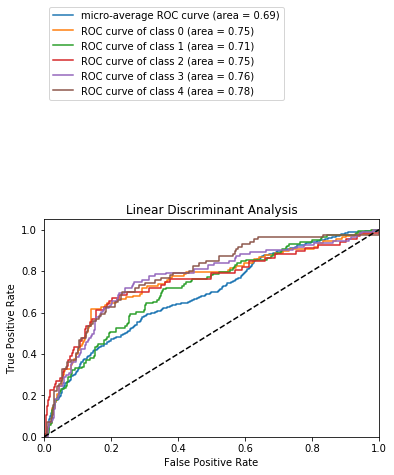

In [68]:
y = label_binarize(num_label, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(df.speeches, y, test_size=.5,random_state=0)
cv = CountVectorizer()
cv.fit(X_train)
X_train,X_test = cv.transform(X_train),cv.transform(X_test)
classifier = OneVsRestClassifier(LinearDiscriminantAnalysis())
y_score = classifier.fit(X_train.toarray(), y_train).predict_proba(X_test)
#y_score[:,0]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:,i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Linear Discriminant Analysis")
plt.legend(bbox_to_anchor=(0, 2), loc='upper left', ncol=1)
plt.show()

## Doc2vec

In [69]:
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec


D:\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [70]:
def Labeled(s,l):
    sentences = []
    for i,talk in enumerate(s):
        sentences.append(LabeledSentence(utils.to_unicode(talk).split(),[l[i]]))
    return sentences


In [71]:

X_train, X_test, y_train,y_test = train_test_split(np.array(df.speeches),np.array(df["labels"]),train_size=0.8,random_state=42)

In [72]:
score = []

## Checking model performance for single epoch training.

### having a hold-out set before sending the data into Doc2Vec model.

In [73]:


X_train, X_test, y_train,y_test = train_test_split(np.array(df.speeches),np.array(df["labels"]),train_size=0.8,random_state=2)

sentences = Labeled(X_train,y_train)

model_split = Doc2Vec(min_count=1, window=10, size=128, sample=1e-4, negative=5, workers=7)

model_split.build_vocab(sentences)

model_split.train(sentences)


X_seen = []
for doc_id in range(len(sentences)):
    inferred_vector = model_split.infer_vector(sentences[doc_id].words)
    X_seen.append(inferred_vector)


unseen = []
test_ = []
for doc_id in range(len(X_test)):
    inferred_vector = model_split.infer_vector(X_test[doc_id].split())
    unseen.append(inferred_vector)
    d = dict(model_split.docvecs.most_similar([inferred_vector],topn=len(model_split.docvecs)))
    maxkey_test = max(d, key=lambda y: abs(d[y]))
    test_.append(maxkey_test)

sum(test_==y_test)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
D:\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


ValueError: You must specify either total_examples or total_words, for proper job parameters updationand progress calculations. The usual value is total_examples=model.corpus_count.

In [162]:
116/len(y_test)


0.5918367346938775

## Training over multiple epochs :

In [229]:
X_train, X_test, y_train,y_test = train_test_split(np.array(df.speeches),np.array(df["labels"]),train_size=0.8,random_state=2)

In [150]:
for epoch in range(10):
    
    model_split.train(sentences)
    model_split.alpha -=0.02


In [204]:
model_split.most_similar("computer")

[('machine', 0.8952854871749878),
 ('software', 0.8892062306404114),
 ('design', 0.8576284646987915),
 ('device', 0.8553940057754517),
 ('monitor', 0.8490395545959473),
 ('building', 0.8460160493850708),
 ('version', 0.839483916759491),
 ('screen', 0.8357470631599426),
 ('video', 0.8334006071090698),
 ('board', 0.8266938924789429)]

In [152]:

X_seen = []
# loop over the length of documents/sentences
for doc_id in range(len(sentences)):
    # infer the vector for each of the doc
    inferred_vector = model_split.infer_vector(sentences[doc_id].words)
    # append to the empty list
    X_seen.append(inferred_vector)


In [219]:
unseen = []
test_ = []


# Loop over the length of unseen data
for doc_id in range(len(X_test)):
    #infer the vector for each of the unseen document
    inferred_vector = model_split.infer_vector(X_test[doc_id].split())
    # Add that to our empty list
    unseen.append(inferred_vector)
    

## Random Forest on Doc2Vec

In [230]:
RF = RandomForestClassifier(n_estimators=3000)
RF.fit(X_seen,y_train)
p = RF.predict(unseen)
accuracy_score(y_test,p)

0.5714285714285714

In [231]:
print("accuracy Random Forest :",accuracy_score(y_test,p))

accuracy Random Forest : 0.571428571429


## KNN on Doc2Vec

In [223]:
score = []
for n in range(2,30):
    KNN = KNeighborsClassifier(n_neighbors=n)
    KNN.fit(X_seen,y_train)
    p = KNN.predict(unseen)
    score.append(accuracy_score(y_test,p))
    #print("Accuracy KNN: ",accuracy_score(y_test,p)*100)

In [227]:
best_k = range(2,30)[argmax(score)]
print("best k value:",best_k)

best k value: 4


In [228]:
KNN = KNeighborsClassifier(n_neighbors=best_k)
KNN.fit(X_seen,y_train)
p = KNN.predict(unseen)

print("Accuracy KNN: ",accuracy_score(y_test,p)*100)

Accuracy KNN:  56.6326530612


## Modeling Doc2Vec on the whole data for  Search  ( Information Retrevial)

### We can infer vectors for any keywords from this model. We then compare this vector with all the document vectors to find the highest cosine similarity.

In [234]:
sentences_all = Labeled(df.speeches,df["labels"])

model = Doc2Vec(min_count=1, window=10, size=128, sample=1e-4, negative=5, workers=7)

model.build_vocab(sentences_all)

model.train(sentences)


X = []
for doc_id in range(len(sentences_all)):
    inferred_vector = model.infer_vector(sentences_all[doc_id].words)
    X.append(inferred_vector)


## Kmeans on Doc2Vec document vectors

In [88]:
s = []
for i in range(2,30):
    km = KMeans(n_clusters=i)
    km.fit(X)
    p = km.predict(X)
    s.append(silhouette_score(X,p))

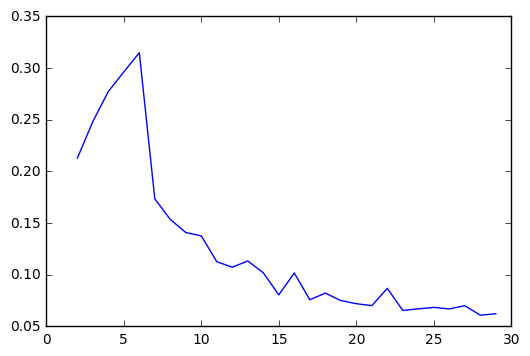

In [913]:
plot(range(2,30),s)

In [635]:
range(2,30)[np.argmax(s)]

5

> We can see that the best cluster size is 5.


In [895]:
X=np.array(X)

In [171]:
label = np.array(df["labels"])
for i,j in enumerate(["t","e","b","g","s"]):
    label[np.where(np.array(df["labels"])==j)]=i

## Visualizing Doc2Vec  Document vectors using TSNE

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


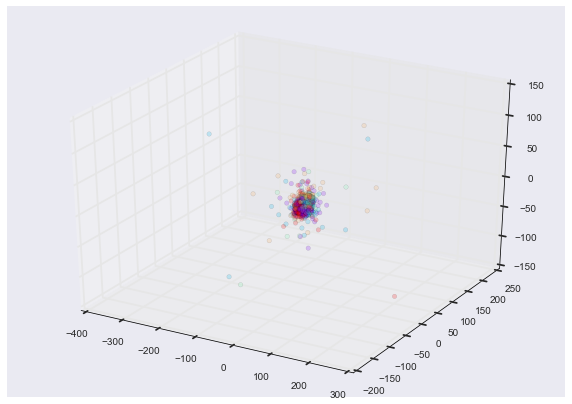

In [172]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



tsne = TSNE(n_components=5)
new_x = tsne.fit_transform(X)

fig = pylab.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection ="3d")
sc = ax.scatter(new_x.T[0],new_x.T[1],new_x.T[2],c=label,alpha=0.2,cmap=plt.cm.rainbow)

## Visualizing Doc2Vec document vectors using the MSD , which is  a manifold similarity based plot.

## We did this on tfidf doc vectors and noticed that there is no proper cluster indication.

## We can see the clusters clearly here

In [174]:

dist = 1 - cosine_similarity(X)


MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys, zs = pos[:, 0], pos[:, 1],pos[:,2]



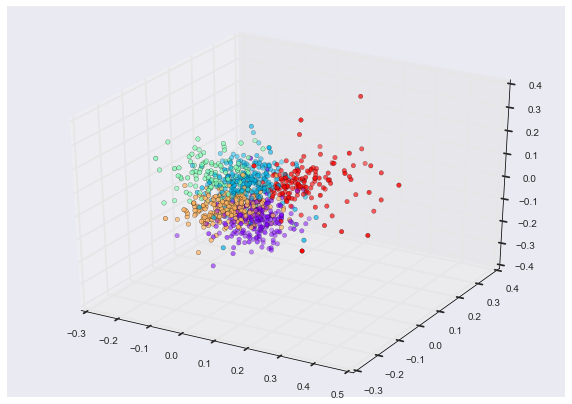

In [177]:

fig = pylab.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection ="3d")
sc = ax.scatter(xs,ys,zs,c=num_label,cmap=plt.cm.rainbow)

## Search

## We are giving "computer"  as  a search keyword. 

## Infer the vector for "computer" and compare it with all other doc vevtors

In [235]:
X=  np.array(X)
vec = model.infer_vector("computer".split())
t=np.array(labels)[argsort((X.dot(vec)))[::-1]]

In [256]:
t[:10]

array(['t', 't', 't', 't', 't', 't', 't', 't', 't', 't'], 
      dtype='<U1')

> t --> technology

> We can see the top 10 results  and almost all the inital results are technology related. our search was "computer"

## LSA

## I'll be printing the categories of the retreived documents  because its hard to judge the output using the title.

In [265]:

v = []

query = "computer"

svd = TruncatedSVD(n_components=700)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(vectorized_tfidf)

X_dense = svd.inverse_transform(X)


query = "".join(char for char in query.lower() if char not in punctuation).split()

vocab = tfidf_model.get_feature_names()

query=np.array([1 if q in q else 0 for q in vocab])

if np.count_nonzero(query==1)==0:
    print("Keywords don't match with documents")
else:
    score = query.dot(X_dense.T)
    sort = sorted(zip(range(1,len(score)+1),score),key=lambda x:x[1],reverse=True)

    for i in range(len(sort[:10])):
        print((labels)[sort[i][0]])



s
b
b
b
e
g
s
g
t
s


Doc2Vec performs better than LSA. That's because the LSA model doesnt consider the best low-rank approximation of the oriiginal TFIDF matrix.

We can check how good the approximation is by computing Frobenius index. I did not have enough time to tune the LSA model. I was more focused on understanding Doc2Vec.

I had implemented LSA from scratch on the 20 news groups data, for which I computed the frobenius indx and tuned it. You can look at my other project repos on github to find it.

----------------------

# Just a fun thing  that I wanted to try

## Trying to predict number of views using number of pauses, laughters, applauses, sentiment :

In [283]:

X = df_eda[["pause","questions","laughter","applause","sentiment"]].values
y = np.array(df_eda.views)

model = sm.OLS(y.astype(int), X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     99.06
Date:                Fri, 16 Dec 2016   Prob (F-statistic):           1.83e-84
Time:                        14:48:35   Log-Likelihood:                -15744.
No. Observations:                 978   AIC:                         3.150e+04
Df Residuals:                     973   BIC:                         3.152e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -4426.8754   3089.948     -1.433      0.152   -1.05e+04    1636.854
x2          1.404e+04   6512.143      2.157      0.031    1264.182    2.68e+04
x3           3.27e+04   6511.696      5.021      0.000    1.99e+04    4.55e+04
x4          1.569e+05   1.77e+04      8.861      0.000    1.22e+05    1.92e+05
x5          3.308e+06   7.94e+05      4.165      0.000    1.75e+06    4.87e+06
==============================================================================
Omnibus:                     1277.403   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           291229.961
Skew:                           6.737   Prob(JB):                         0.00
Kurtosis:                      86.458   Cond. No.                         390.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Since we are able to explain only 34% of the variance. we cant use this to predict the views.

# Accuracy on TFIDF :

### SVM = 78%

### Random forest = 63%

### knn = 65%

### gradient boosting = 54%

### LDA =  49 %

# Accuracy on Doc2Vec document vectors :

### Random Forest = 57%

### Knn = 56.6%





# SVM Classifier gave me the best performance:


## parameters : [SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
## decision_function_shape=None, degree=3, gamma=1, kernel='sigmoid',
## max_iter=-1, probability=False, random_state=None, shrinking=True,
##  tol=0.001, verbose=False)]